In [1]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import torch.nn.functional as F
from torch.amp import GradScaler

import warnings
warnings.filterwarnings("ignore")

/root/miniconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration (Use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Hyperparameters
batch_size = 100
num_classes = 10
learning_rate = 0.001
num_epochs = 5

# Define the transform to resize Fashion MNIST images and convert to 3 channels (RGB)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
saved_model_path = 'teacher models/bitm_resnet50x1_FMnist.pth'

# Load the BiT model (ResNet50x1)
teacher_model = timm.create_model('resnetv2_50x1_bitm', pretrained=False, num_classes=num_classes)

# Load the state dictionary
state_dict = torch.load(saved_model_path)
teacher_model.load_state_dict(state_dict)

# Move the model to the GPU device
teacher_model.to(device)
teacher_model.eval()  # Set the model to evaluation mode

print("Teacher model loaded successfully!")

Teacher model loaded successfully!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].


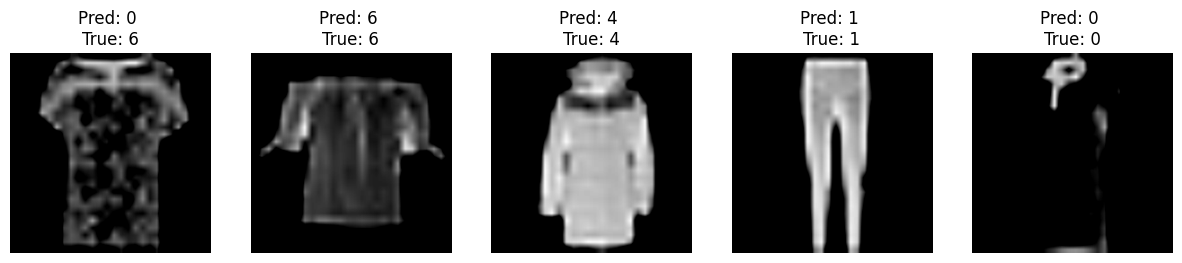

In [5]:
import matplotlib.pyplot as plt
import random

def predict_and_visualize(model, data_loader, num_images=5):
    model.eval()
    
    # Convert the DataLoader to a list for easy shuffling
    data_list = list(data_loader)
    
    # Randomly select a batch
    images, labels = random.choice(data_list)
    
    # Select random images from the batch
    random_indices = random.sample(range(len(images)), num_images)
    images, labels = images[random_indices].to(device), labels[random_indices].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].transpose((1, 2, 0)).squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()} \nTrue: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Make predictions and visualize results
predict_and_visualize(teacher_model, test_loader)

In [6]:
# Create the student_model directory if it doesn't exist
import os
os.makedirs('student_models_mobilenet', exist_ok=True)

# Mixed precision scaler
scaler = GradScaler('cuda')

# Distillation Loss Function
def distillation_loss(student_outputs, teacher_outputs, labels, T, alpha):
    hard_loss = F.cross_entropy(student_outputs, labels)
    soft_loss = F.kl_div(
        F.log_softmax(student_outputs / T, dim=1),
        F.softmax(teacher_outputs / T, dim=1),
        reduction='batchmean'
    )
    return alpha * hard_loss + (1 - alpha) * (T * T) * soft_loss

In [7]:
def train_distillation(teacher_model, student_model, train_loader, optimizer, T, alpha, epochs=5, accumulate_steps=4):
    student_model.train()
    teacher_model.eval()
    
    # Create accuracy metric
    num_classes = student_model.num_classes if hasattr(student_model, 'num_classes') else len(train_loader.dataset.classes)
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        accuracy_metric.reset()  # Reset accuracy metric for each epoch
        optimizer.zero_grad()

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}')):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Teacher forward pass (no gradients needed)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)

            # Student forward pass with mixed precision
            with torch.amp.autocast('cuda'):
                student_outputs = student_model(images)
                loss = distillation_loss(student_outputs, teacher_outputs, labels, T, alpha)
            
            # Update accuracy metric
            with torch.no_grad():
                accuracy_metric.update(student_outputs, labels)

            # Accumulate gradients
            scaler.scale(loss).backward()

            # Update weights every accumulate_steps batches
            if (batch_idx + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

            # Free memory
            del images, labels, teacher_outputs, student_outputs, loss
            torch.cuda.empty_cache()
        
        # Compute accuracy for the epoch
        train_accuracy = accuracy_metric.compute().item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy*100:.2f}%')
        
        # Reset accuracy for next epoch
        accuracy_metric.reset()

    return student_model

In [8]:
# Define the quantization function
def quantize_model(model):
    model.cpu()  # Ensure the model is on the CPU
    model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return model

In [9]:
import torch
import torchmetrics

# Function to evaluate the quantized model
def evaluate_model_cpu(model, data_loader):
    model.eval()
    
    num_classes = 10  # Adjust based on dataset
    
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to('cpu')
    precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted').to('cpu')
    recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted').to('cpu')
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted').to('cpu')
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')  # Ensure everything is on CPU
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class
            
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute numerical values
    accuracy_value = accuracy(all_preds, all_labels).item()
    precision_value = precision(all_preds, all_labels).item()
    recall_value = recall(all_preds, all_labels).item()
    f1_value = f1(all_preds, all_labels).item()

    return accuracy_value, precision_value, recall_value, f1_value

In [11]:
# Fine-tuning and saving 3 different student models with ranking
hyperparams_list = [
    {'T': 2.0, 'alpha': 0.5, 'lr': 0.001, 'epochs': 5, 'name': 'student_model_T2_alpha0.5'},
    {'T': 3.0, 'alpha': 0.7, 'lr': 0.0005, 'epochs': 5, 'name': 'student_model_T3_alpha0.7'},
    {'T': 4.0, 'alpha': 0.9, 'lr': 0.0003, 'epochs': 5, 'name': 'student_model_T4_alpha0.9'}
]

results = []

for hyperparams in hyperparams_list:
    student_model = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=num_classes)
    student_model.to(device)
    
    optimizer = torch.optim.Adam(student_model.parameters(), lr=hyperparams['lr'])
    train_distillation(
        teacher_model, student_model, train_loader,
        optimizer, T=hyperparams['T'], alpha=hyperparams['alpha'], epochs=hyperparams['epochs']
    )
    
    # Move the model to CPU and quantize
    student_model = quantize_model(student_model)
    
    # Evaluate the quantized model on CPU
    accuracy_value, precision_value, recall_value, f1_value = evaluate_model_cpu(student_model, test_loader)
    results.append((accuracy_value, precision_value, recall_value, f1_value, student_model))
    
    # Save the state dictionary
    torch.save(student_model.state_dict(), f'student_models_mobilenet/{hyperparams["name"]}.pth')
    del student_model
    torch.cuda.empty_cache()

Training Epoch 1/5: 100%|██████████| 600/600 [05:51<00:00,  1.71it/s]


Epoch [1/5], Loss: 0.6735, Accuracy: 86.07%


Training Epoch 2/5: 100%|██████████| 600/600 [05:52<00:00,  1.70it/s]


Epoch [2/5], Loss: 0.1979, Accuracy: 92.77%


Training Epoch 3/5: 100%|██████████| 600/600 [05:54<00:00,  1.69it/s]


Epoch [3/5], Loss: 0.1627, Accuracy: 93.74%


Training Epoch 4/5: 100%|██████████| 600/600 [05:54<00:00,  1.69it/s]


Epoch [4/5], Loss: 0.1482, Accuracy: 94.33%


Training Epoch 5/5: 100%|██████████| 600/600 [05:56<00:00,  1.68it/s]


Epoch [5/5], Loss: 0.1296, Accuracy: 95.00%


Training Epoch 1/5: 100%|██████████| 600/600 [05:50<00:00,  1.71it/s]


Epoch [1/5], Loss: 0.5755, Accuracy: 87.92%


Training Epoch 2/5: 100%|██████████| 600/600 [05:58<00:00,  1.67it/s]


Epoch [2/5], Loss: 0.2277, Accuracy: 93.35%


Training Epoch 3/5: 100%|██████████| 600/600 [05:52<00:00,  1.70it/s]


Epoch [3/5], Loss: 0.1874, Accuracy: 94.45%


Training Epoch 4/5: 100%|██████████| 600/600 [05:51<00:00,  1.71it/s]


Epoch [4/5], Loss: 0.1677, Accuracy: 95.20%


Training Epoch 5/5: 100%|██████████| 600/600 [05:51<00:00,  1.71it/s]


Epoch [5/5], Loss: 0.1465, Accuracy: 95.94%


Training Epoch 1/5: 100%|██████████| 600/600 [05:52<00:00,  1.70it/s]


Epoch [1/5], Loss: 0.4990, Accuracy: 87.26%


Training Epoch 2/5: 100%|██████████| 600/600 [05:56<00:00,  1.68it/s]


Epoch [2/5], Loss: 0.2331, Accuracy: 93.12%


Training Epoch 3/5: 100%|██████████| 600/600 [06:01<00:00,  1.66it/s]


Epoch [3/5], Loss: 0.1875, Accuracy: 94.54%


Training Epoch 4/5: 100%|██████████| 600/600 [05:56<00:00,  1.68it/s]


Epoch [4/5], Loss: 0.1580, Accuracy: 95.68%


Training Epoch 5/5: 100%|██████████| 600/600 [05:58<00:00,  1.67it/s]


Epoch [5/5], Loss: 0.1436, Accuracy: 96.17%


In [16]:
# Rank and save models
results.sort(reverse=True, key=lambda x: x[0])
for idx, (accuracy_value, precision_value, recall_value, f1_value, model) in enumerate(results):
    torch.save(model.state_dict(), f'student_models_mobilenet/ranked_model_{idx+1}.pth')
    print(f'Model {idx+1} - Accuracy: {accuracy_value*100:.2f}% | Precision: {precision_value*100:.2f}% | Recall: {recall_value*100:.2f}% | F1 Score: {f1_value*100:.2f}%\n')

Model 1 - Accuracy: 93.74% | Precision: 93.82% | Recall: 93.74% | F1 Score: 93.65%

Model 2 - Accuracy: 93.28% | Precision: 93.49% | Recall: 93.28% | F1 Score: 93.34%

Model 3 - Accuracy: 93.17% | Precision: 93.32% | Recall: 93.17% | F1 Score: 93.05%

